In [19]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from RankingFacts.nutrition_label_utility import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
df=pd.read_csv("data/Diabetes_dataset.csv")
df.head(5)

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,1
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,1
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,1
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,0
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,1


In [21]:
def età(row):
    if(row["Age"]>25):
        return 'Adult'
    else:
        return 'Young'

In [22]:
df["AgeCategory"]=df.apply(lambda row: età(row), axis=1)

In [23]:
df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,Adult
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,Adult
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,Adult
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,Young
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,Adult


# Ranking Facts

## Recipe And Ingredients

Recipe: tool which defined the ranking algorithm used by the system 
Ingredients: tool which defined the most important attributes, chosen by computing the correlation with the target variable

In [24]:
# Don't consider the protected attribute when you use the Recipe tool
ignore_atts = ["AgeCategory"] 

In [25]:
cur_data = df.copy()
norm_data = normalizeDataset(cur_data, ignore_atts)
standarded_data = standardizeData(cur_data, ignore_atts)

--------------- CORRELATIONS ---------------
                          Unnamed: 0  Pregnancies   Glucose  BloodPressure  \
Unnamed: 0                  1.000000    -0.029302  0.002671       0.033818   
Pregnancies                -0.029302     1.000000  0.117612       0.207416   
Glucose                     0.002671     0.117612  1.000000       0.204879   
BloodPressure               0.033818     0.207416  0.204879       1.000000   
SkinThickness               0.003522     0.082694  0.147975       0.127232   
Insulin                     0.041517    -0.084574  0.129853      -0.032427   
BMI                         0.008665     0.024749  0.229098       0.269477   
DiabetesPedigreeFunction   -0.039756    -0.020653  0.053722      -0.023258   
Age                        -0.017105     0.558950  0.274576       0.325335   
Outcome                    -0.048495     0.199243  0.494650       0.163178   

                          SkinThickness   Insulin       BMI  \
Unnamed: 0                     0.

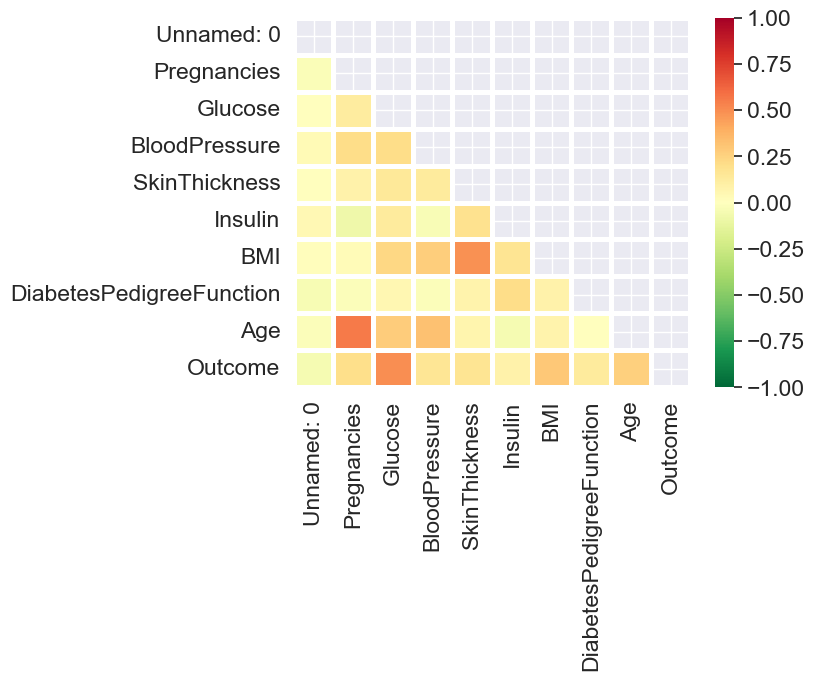

In [26]:
corr_df = standarded_data.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df.head(len(df)))
print("--------------- CREATE A HEATMAP ---------------")
# Create a mask to display only the lower triangle of the matrix 
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [27]:
chosen_atts = ["Glucose", "Age", "BMI"]
weights = [1, 1, 1]


In [28]:
norm_data["Score"] = sum([weights[idx]*norm_data[atti] for idx, atti in enumerate(chosen_atts)])
df["Score"] = sum([weights[idx]*df[atti] for idx, atti in enumerate(chosen_atts)])
df.head(10)

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory,Score
0,0,6.0,148,72.0,35.0,30.50,33.6,0.627,50.0,1,Adult,231.6
1,1,1.0,85,66.0,29.0,30.50,26.6,0.351,31.0,0,Adult,142.6
2,2,8.0,183,64.0,23.0,30.50,23.3,0.672,32.0,1,Adult,238.3
3,3,1.0,89,66.0,23.0,94.00,28.1,0.167,21.0,0,Young,138.1
4,4,0.0,137,40.0,35.0,168.00,43.1,0.374,33.0,1,Adult,213.1
5,5,5.0,116,74.0,23.0,30.50,25.6,0.201,30.0,0,Adult,171.6
6,6,3.0,78,50.0,32.0,88.00,31.0,0.248,26.0,1,Adult,135.0
7,7,10.0,115,72.0,23.0,30.50,35.3,0.134,29.0,0,Adult,179.3
8,8,2.0,197,70.0,45.0,31.25,30.5,0.158,53.0,1,Adult,280.5
9,9,8.0,125,96.0,23.0,30.50,32.0,0.232,54.0,1,Adult,211.0


# FAIRNESS

In [29]:
def compute_p_FAIR(_data, _att, _protected_group, _y_col="Score", top_k = 100, round_default = 2):
    """
    Compute p-value using FA*IR algorithm

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        top_k: the top ranking to verify group fairness
        round_default: threshold of round function
    Return:  rounded p-value and adjusted significance level in FA*IR
    """
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    if len(_data)/2 < top_k:
        top_k = int(len(_data)/2)
    pos_protected = _data[_data[_att]==_protected_group].index+1
    pro_prob = len(pos_protected)/len(_data)

    # transform ranking to a ranking of tuples with (id,"pro")/(id,"unpro") to run FA*IR
    transformed_ranking = []
    for index, row in _data.head(top_k).iterrows():
        if row[_att] == _protected_group:
            transformed_ranking.append([index,"pro"])
        else:
            transformed_ranking.append([index,"unpro"])

    p_value, isFair, posiFail, alpha_c, pro_needed_list = computeFairRankingProbability(top_k, pro_prob, transformed_ranking)
    return p_value, isFair, posiFail, round(alpha_c,round_default)

In [30]:
sensi_att = "AgeCategory" 
protected_groups = norm_data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p, fair_res, pos_fail, vi_alpha = compute_p_FAIR(norm_data, sensi_att, vi)
    if fair_res:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha="+str(vi_alpha)+") ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha="+str(vi_alpha)+") FAIL AT RANK POSITION "+str(pos_fail)+" ---------")

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING AgeCategory ---------------
--------------- FAIR FOR Adult (p=0.9999999999999908, alpha=0.79) ---------------
--------------- UNFAIR FOR Young (p=1.2009254734231408e-13, alpha=0.81) FAIL AT RANK POSITION 7 ---------


In [31]:
def compute_p_pairs(_data, _att, _protected_group, _y_col="Score", run_time = 100, round_default = 2):
    """
    Compute p-value using Pairwise oracle

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        run_time: simulation times for pairwise comparison
        round_default: threshold of round function
    Return:  rounded p-value
    """
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    pos_protected = _data[_data[_att]==_protected_group].index+1
    pro_prob = len(pos_protected)/len(_data)
    total_n = len(_data)
    pro_n = len(pos_protected)
    seed_random_ranking = [x for x in range(total_n)]  # list of IDs
    seed_f_index = [x for x in range(pro_n)]  # list of IDs
    
    sim_df = pd.DataFrame(columns=["Run", "pair_n"])
    # run the simulation of ranking generation, in each simulation, generate a fair ranking with input N and size of sensitive group
    for ri in range(run_time):
        output_ranking = mergeUnfairRanking(seed_random_ranking, seed_f_index, pro_prob)
        position_pro_list = [i for i in range(total_n) if output_ranking[i] in seed_f_index]
        count_sensi_prefered_pairs = 0
        for i in range(len(position_pro_list)):
            cur_position = position_pro_list[i]
            left_sensi = pro_n - (i + 1)
            count_sensi_prefered_pairs = count_sensi_prefered_pairs + (total_n - cur_position - left_sensi)
        cur_row = [ri + 1, count_sensi_prefered_pairs]
        sim_df.loc[sim_df.shape[0]] = cur_row

    input_pair_n, _, _ = computePairN(_att, _protected_group, _data)
    pair_samples = list(sim_df["pair_n"].dropna())
    return round(Cdf(pair_samples, input_pair_n), round_default)

In [32]:
sensi_att =  "AgeCategory"

protected_groups = norm_data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p = compute_p_pairs(norm_data, sensi_att, vi)
    if vi_p > 0.05:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) --------------") 

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING AgeCategory ---------------
--------------- FAIR FOR Adult (p=1.0, alpha=0.05) ---------------
--------------- UNFAIR FOR Young (p=0.0, alpha=0.05) --------------


In [33]:
def compute_p_proportion(_data, _att, _protected_group, _y_col="Score", top_k = 100, round_default = 2):
    """
    Compute p-value using Proportion oracle, i.e., z-test method of 4.1.3 in "A survey on measuring indirect discrimination in machine learning".

    Attributes:
        _data: dataframe that stored the data
        _att: sensitive attribute name
        _protected_group: the value of sensitive attribute for protected group
        _y_col: the column that stores the values of ranking
        top_k: the top ranking to verify group fairness
        round_default: threshold of round function
    Return:  rounded p-value
    """
    
    _data.sort_values(by=_y_col, ascending=False, inplace=True)
    _data.reset_index(drop=True, inplace=True)
    if len(_data)/2 < top_k:
        top_k = int(len(_data)/2)
    total_n = len(_data)
    pro_n = len(_data[_data[_att]==_protected_group])
    unpro_n = total_n - pro_n
    
    top_data = _data.head(top_k)
    pro_k = len(top_data[top_data[_att]==_protected_group])
    unpro_k = top_k - pro_k
    

    pooledSE = math.sqrt((pro_k / pro_n * (1-pro_k/pro_n) / pro_n) + (unpro_k/unpro_n * (1-unpro_k/unpro_n) / unpro_n))
    
    z_test = (unpro_k/unpro_n - pro_k/pro_n) / pooledSE
    p_value = norm.sf(z_test)

    return round(p_value,round_default)

In [34]:
sensi_att = "AgeCategory"

protected_groups = norm_data[sensi_att].unique()
print("--------------- GROUP FAIRNESS VERIFICATION CONSIDERING "+sensi_att+" ---------------") 
for vi in protected_groups:
    vi_p = compute_p_proportion(norm_data, sensi_att, vi)
    if vi_p > 0.05:
        print("--------------- FAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) ---------------") 
    else:
        print("--------------- UNFAIR FOR "+vi+" (p="+str(vi_p)+", alpha=0.05) --------------") 

--------------- GROUP FAIRNESS VERIFICATION CONSIDERING AgeCategory ---------------
--------------- FAIR FOR Adult (p=1.0, alpha=0.05) ---------------
--------------- UNFAIR FOR Young (p=0.0, alpha=0.05) --------------


# STABILITY

In [35]:
def visualize_stability(_data, _y_col="Score", _top_n=100):
    plt.figure(figsize=[6,5],dpi=100)
    sns.set(style="darkgrid")  
    sns.set(font_scale = 1.5)
    vis_data = _data.head(_top_n)
    vis_x = [x+1 for x in vis_data.index]
    vis_y = sorted(vis_data[_y_col], reverse=True)
    ax = sns.scatterplot([vis_x, vis_y]);
    ax.set_xlabel("Position")
    ax.set_ylabel(_y_col)
    #plt.axis([40, 100, 0, 30])
    plt.tight_layout()
def compute_slope_scores(_data, _y_col="Score", round_default=10):
    """
    Compute the slop of a list of scores.

    Attributes:
        _data: file name that stored the data
        _y_col: column name of Y variable
        round_default: threshold of round function for the returned stability
    Return:  slope of scores in the input _data
    """
    xd = [i for i in range(1,len(_data)+1)]
    yd = _data[_y_col].values
    par = np.polyfit(xd, yd, 1, full=True)
    slope = par[0][0]
    return abs(round(slope, round_default))

In [36]:
top10_stability = compute_slope_scores(df.head(10))
if top10_stability <= 0.25:
    print("--------------- UNSTABLE AT TOP 10 (STABILITY AS "+str(top10_stability)+") ---------------") 
else:
    print("--------------- STABLE AT TOP 10 (STABILITY AS "+str(top10_stability)+") ---------------") 
all_stability = compute_slope_scores(df.head(100))
if all_stability <= 0.25:
    print("--------------- UNSTABLE AT TOP 100(STABILIY AS "+str(all_stability)+") ---------------") 
else:
    print("--------------- STABLE AT TOP 100(STABILIY AS "+str(all_stability)+") ---------------")     
visualize_stability(df)

--------------- STABLE AT TOP 10 (STABILITY AS 2.6309090909) ---------------
--------------- STABLE AT TOP 100(STABILIY AS 0.3578211821) ---------------


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 600x500 with 0 Axes>

# DIVERSITY

In [ ]:
def visualize_diversity(_data, _att, _y_col="Score"):
    plt.figure(figsize=[6,5],dpi=100)
    sns.set(font_scale = 1)
    sns.set_palette(palette="pastel")
    sort_data = _data.sort_values(by=_y_col, ascending=False)
    vis_count = sort_data[_att].value_counts()
    plt.pie(list(vis_count.values), labels=list(vis_count.index));
    plt.title(_att)
    plt.tight_layout()

In [ ]:
sort_data = df.sort_values(by=["Score"], ascending=False)

In [ ]:
chosen_atts = ["AgeCategory"]
for atti in chosen_atts:
    visualize_diversity(sort_data.head(10), atti)

In [ ]:
for atti in chosen_atts:
    visualize_diversity(sort_data, atti)